In [96]:
import time
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import nbimporter
from OptiEngine import FEM_2D, Config, Timer, optimize

In [97]:
from NeuralNetwork_First_Iter import TopologyGenerator_FirstIter
from NeuralNetwork_Predict_First_Iter import FirstIter_Predictor

In [98]:
predictor = FirstIter_Predictor()
generator = TopologyGenerator_FirstIter()

In [99]:
fiter_predictor_loadname = 'NeuralNetwork_Predict_First_Iter_params'
topology_generator_loadname = 'NeuralNetwork_FirstIter_params'

In [100]:
predictor.load_state_dict(torch.load(fiter_predictor_loadname))
generator.load_state_dict(torch.load(topology_generator_loadname))

<All keys matched successfully>

In [101]:
def gen_design(task, predictor, generator):
    fiter_predict = predictor(torch.FloatTensor(task).reshape(1,1,30,30)).detach().reshape(29,29)
    topology_predict = generator(torch.FloatTensor(fiter_predict).reshape(1,1,29,29)).detach().reshape(29,29)
    return topology_predict

In [102]:
def save_design(design_matrix, save_name, threshold):
    new_matr = np.copy(design_matrix)
    new_matr[new_matr > threshold] = 1.0
    new_matr[new_matr <= threshold] = 0.0
    np.savetxt(save_name, new_matr)

In [103]:
custom_task = np.zeros((30,30))
custom_task[5][0] = -1
custom_task[10][29] = 1
custom_task[29][29] = 1

timer = Timer()
timer.start()
nn_design = gen_design(custom_task, predictor, generator)
nn_time = timer.time_passed()

In [104]:
config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 40

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(10, 29, True, True)
FEM_solver.fix_node(29, 29, True, True)
FEM_solver.apply_load(5, 0, 0, -1)

timer.start()
FEM_solver.form_elements()
config.H, config.sH = FEM_solver.prepare_filter()
xPhys_opt = optimize(FEM_solver, config, False, False)

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]
        
simp_time = timer.time_passed()

Text(0.5, 1.0, 'Neural Network design: ')

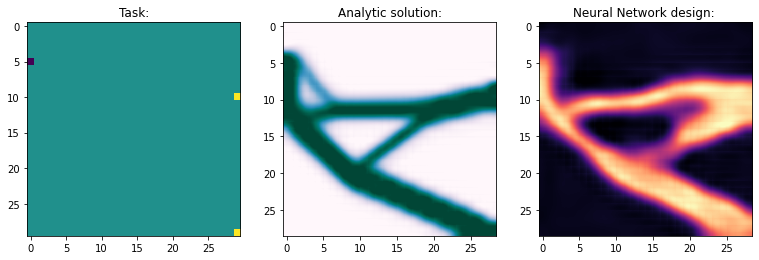

In [105]:
fig, axes = plt.subplots(1,3, figsize = (13,13))

axes[0].imshow(custom_task)
axes[0].set_title('Task:')
axes[1].imshow(x_matrix, interpolation = 'bessel', cmap = 'PuBuGn')
axes[1].set_title('Analytic solution:')
axes[2].imshow(nn_design, interpolation = 'bessel', cmap = 'magma')
axes[2].set_title('Neural Network design: ')

In [86]:
print(f'Simp design taken: {simp_time}')
print(f'NN design taken: {nn_time}')

Simp design taken: 6.58289099
NN design taken: 0.00499535


In [77]:
save_design(nn_design, 'NN_Optim.txt', 0.2)

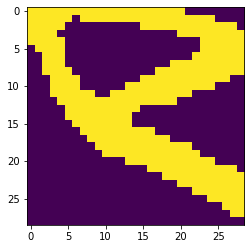

In [78]:
plt.imshow(np.loadtxt('NN_Optim.txt'))